# 作業 2.
請透過 Kaggle - eCommerce Events History in Cosmetics Shop 資料集，以最少⼀個⽉以上的資料進⾏⽤戶分群研究。請最少以⼀⾴簡報說明分析方法論與分析過程、以⼀⾴簡報說明分群結果與經營建議。

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt

# Load the data
data_directory = 'C:/Users/nazwa/Documents/datascience/infoshare/big_data_project/jdszr16-datapaparapa/data/raw/cosmetics/'
data_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
data = pd.concat([pd.read_csv(os.path.join(data_directory, file)) for file in data_files])
data['event_time'] = data['event_time'].str.replace(' UTC', '')
data['event_time'] = pd.to_datetime(data['event_time'], format="%Y-%m-%d %H:%M:%S", utc=True)

## EDA
Key Takeaways:
* Price Distribution has a long tail, may need to normalize by log()
* Category Code has too much missing values, should be exclude from models, but reserve for interpretation (e.g. Basket Analysis)
* No significantly dominant brands
* No collinearty needed to be check, only price is a numeric variable.
* Session Unique Value Number is way less than total values, meaning that a customer would take multiple actions in a session on average

In [22]:
data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_time_polar,actions_per_session,user_avg_actions_per_session,user_total_actions,behavior_type
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,0.000000,466.0,2.925676,1299,Active User
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,0.000000,41.0,3.518519,95,Active User
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,0.000000,99.0,64.000000,128,Active User
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,0.000000,44.0,17.000000,85,Active User
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,0.000000,18.0,3.210526,61,Active User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20692704,2020-01-31 23:59:52+00:00,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47,6.278822,10.0,7.545455,83,Active User
20692705,2020-01-31 23:59:52+00:00,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47,6.278822,10.0,7.545455,83,Active User
20692706,2020-01-31 23:59:53+00:00,view,5875432,2084144451428549153,NaN,NaN,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80,6.278822,18.0,10.428571,146,Active User
20692707,2020-01-31 23:59:57+00:00,remove_from_cart,5820745,1487580006317032337,NaN,NaN,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47,6.278822,10.0,7.545455,83,Active User


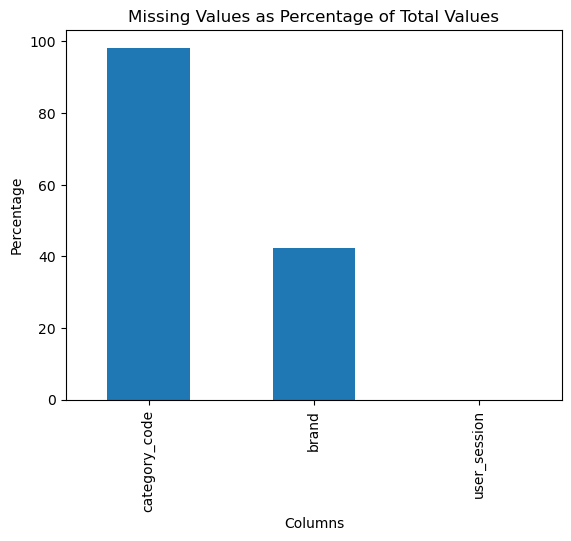

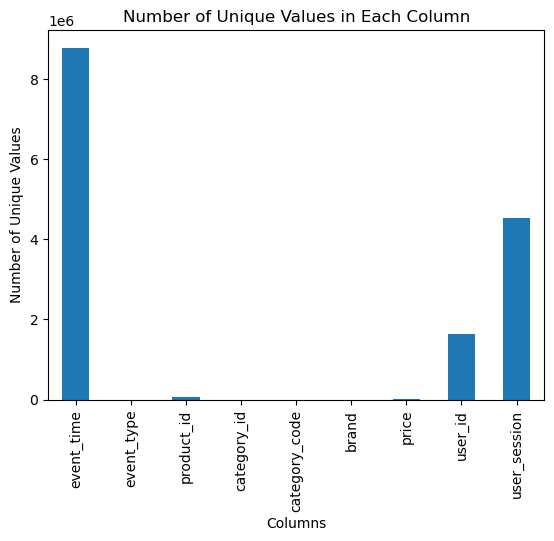

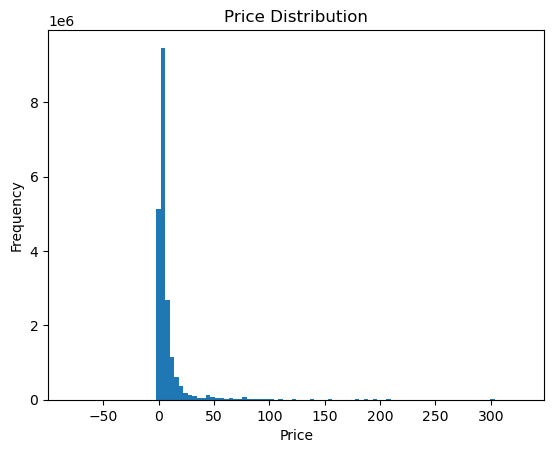

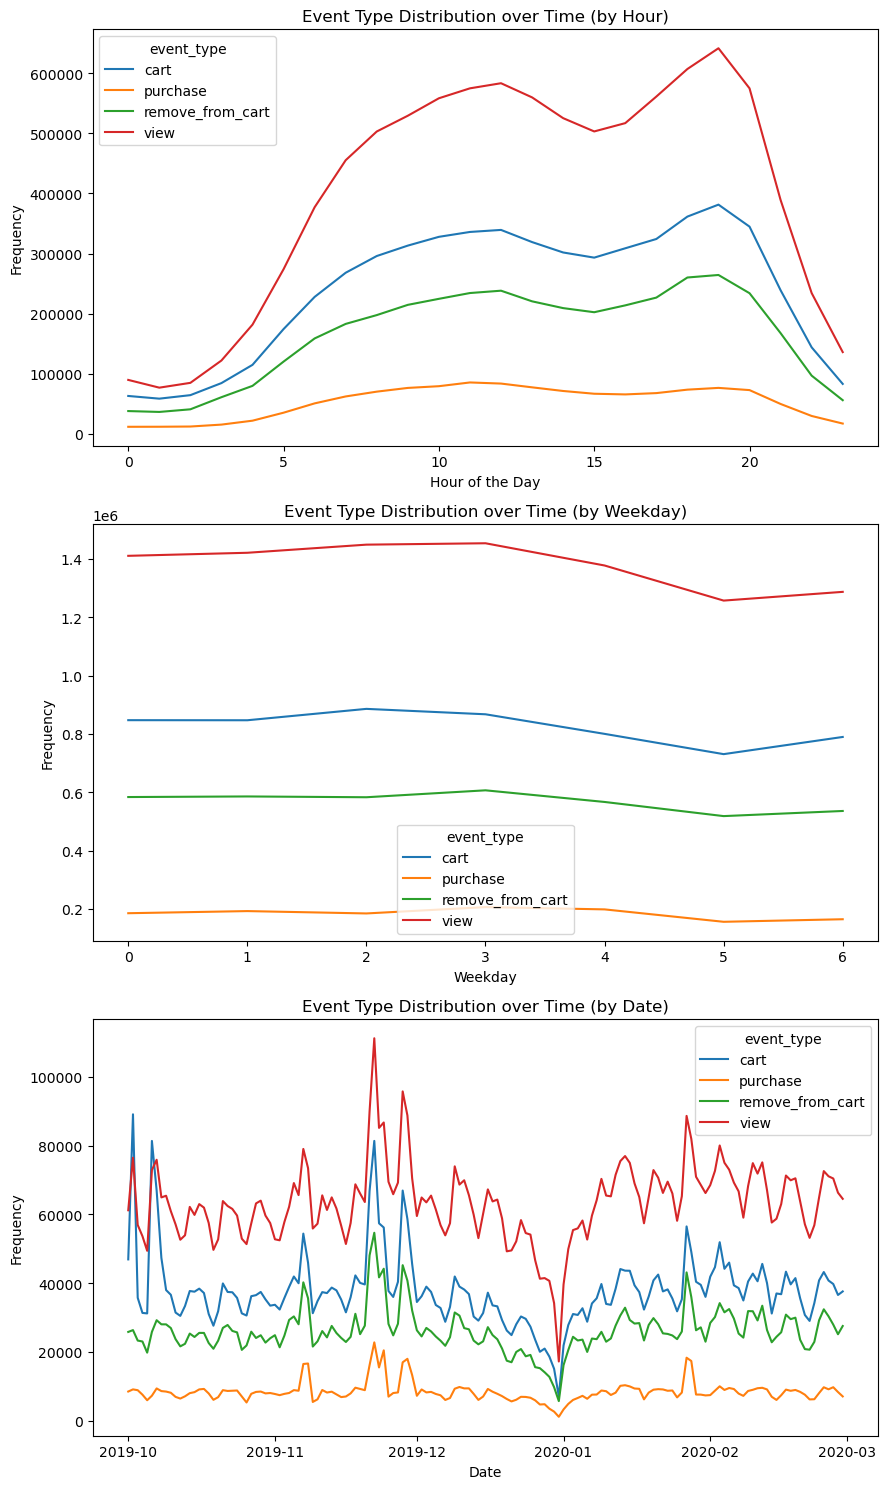

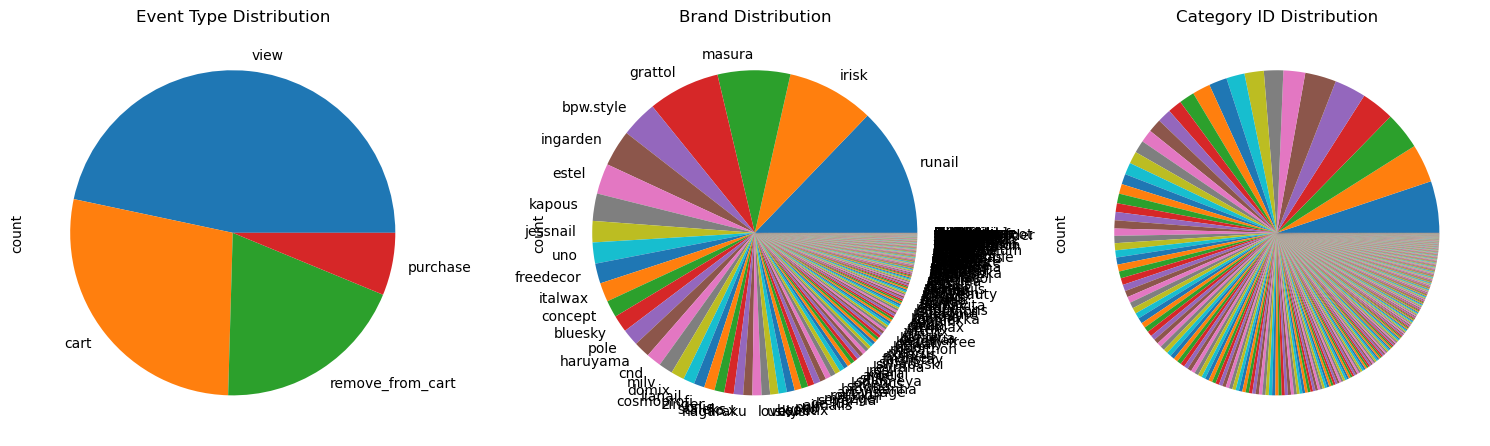

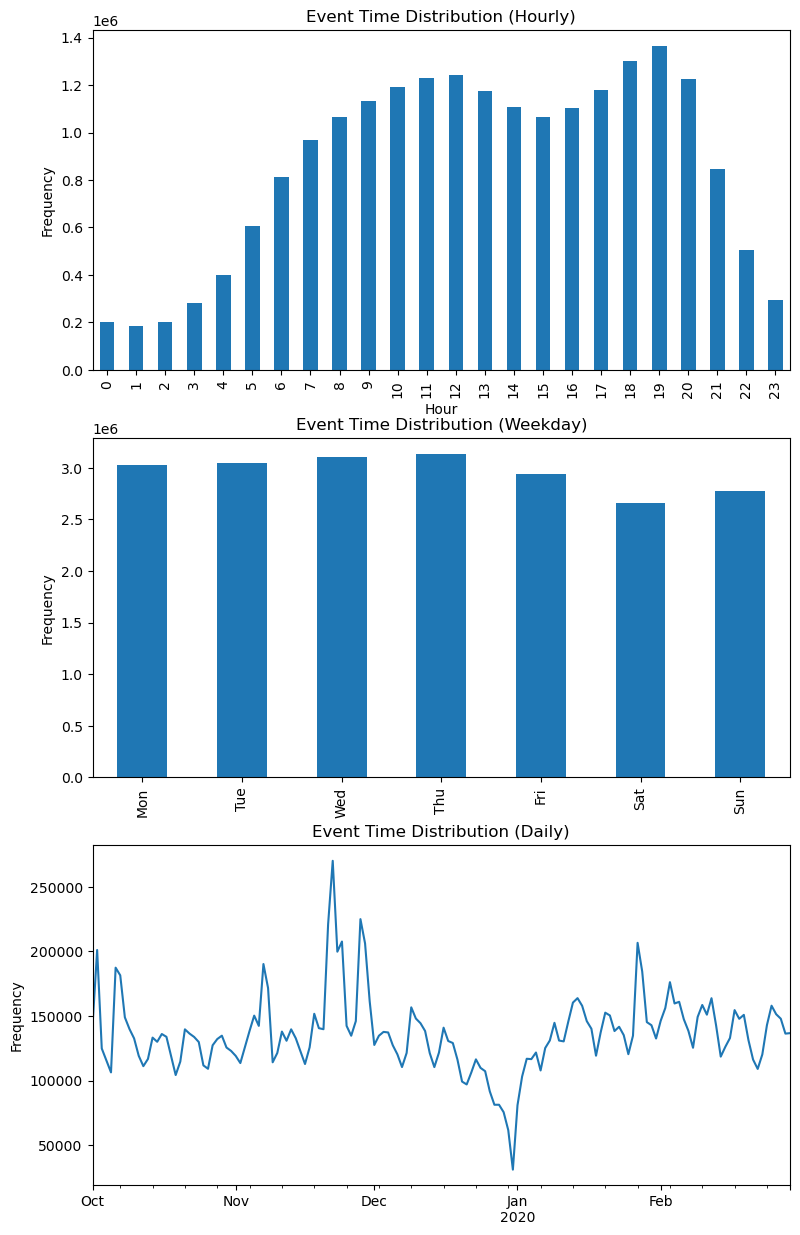

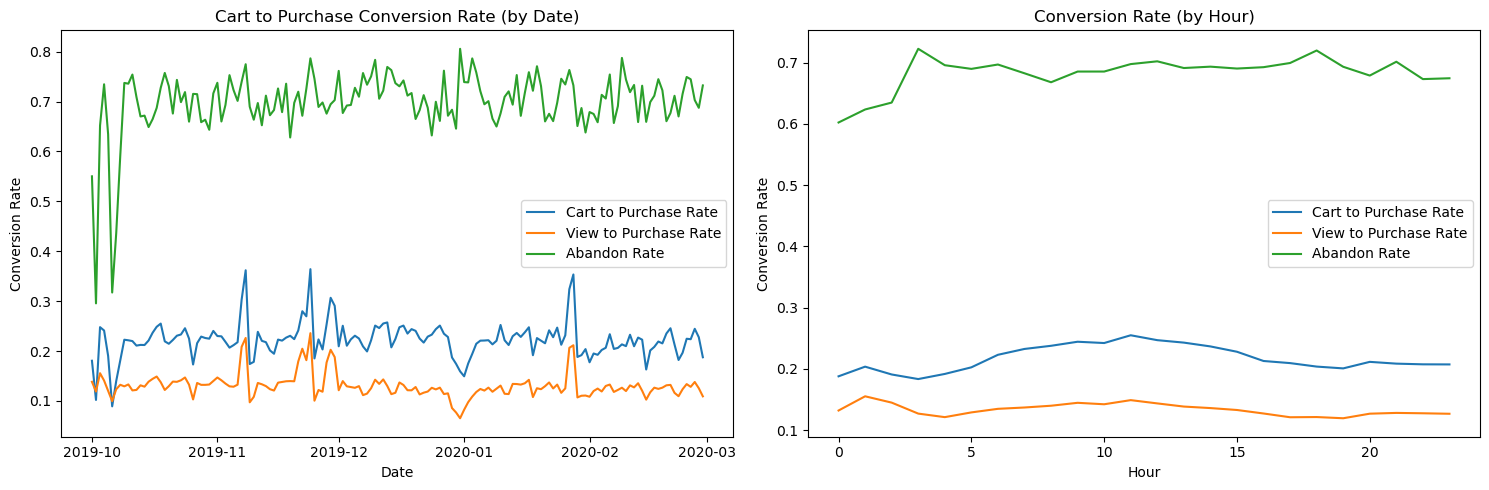

In [2]:
# Check missing values (as Percentage of Total Values)
missing = data.isnull().sum()
missing = missing[missing > 0]
missing = missing.apply(lambda x: x / data.shape[0] * 100).sort_values(ascending=False)
missing.plot(kind='bar')
plt.title('Missing Values as Percentage of Total Values')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.show()

# Check unique values count
data.nunique().plot(kind='bar')
plt.title('Number of Unique Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.show()

# Check distributions
data['price'].plot(kind='hist', bins=100)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Eliminate negative prices
data = data[data['price'] >= 0]

def plot_datetime_distribution(data):
    fig, axs = plt.subplots(3, 1, figsize=(9, 15))

    # Plot the event type distribution over time (by date)
    data.groupby(data['event_time'].dt.date)['event_type'].value_counts().unstack().plot(kind='line', ax=axs[2])
    axs[2].set_title('Event Type Distribution over Time (by Date)')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Frequency')

    # Plot the event type distribution over time (by hour)
    data.groupby(data['event_time'].dt.hour)['event_type'].value_counts().unstack().plot(kind='line', ax=axs[0])
    axs[0].set_title('Event Type Distribution over Time (by Hour)')
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Frequency')

    # Plot the event type distribution over time (by weekday)
    data.groupby(data['event_time'].dt.weekday)['event_type'].value_counts().unstack().plot(kind='line', ax=axs[1])
    axs[1].set_title('Event Type Distribution over Time (by Weekday)')
    axs[1].set_xlabel('Weekday')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_datetime_distribution(data)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the event type distribution
data['event_type'].value_counts().plot(kind='pie', ax=axs[0])
axs[0].set_title('Event Type Distribution')

# Plot the brand distribution
data['brand'].value_counts().plot(kind='pie', ax=axs[1])
axs[1].set_title('Brand Distribution')

# Plot the category ID distribution
data['category_id'].value_counts().plot(kind='pie', ax=axs[2], labels=None)
axs[2].set_title('Category ID Distribution')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(9, 15))

# Plot hourly distribution
hourly_sum = data.groupby(data['event_time'].dt.hour)['event_time'].count()
axes[0].set_title('Event Time Distribution (Hourly)')
hourly_sum.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Frequency')

# Plot daily distribution
daily_sum = data.resample('D', on='event_time').count()
axes[2].set_title('Event Time Distribution (Daily)')
daily_sum['event_type'].plot(ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Frequency')

# Plot weekday distribution
weekday_sum = data.groupby(data['event_time'].dt.weekday)['event_time'].count()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].set_title('Event Time Distribution (Weekday)')
weekday_sum.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(weekday_labels)
plt.show()

del weekday_labels, weekday_sum, daily_sum, hourly_sum, fig, axes, missing # delete variables to free up memory

purchase_data = data[data['event_type'] == 'purchase']
cart_data = data[data['event_type'] == 'cart']
view_data = data[data['event_type'] == 'view']
remove_data = data[data['event_type'] == 'remove_from_cart']

purchase_data_date = purchase_data.groupby(purchase_data['event_time'].dt.date)['event_type'].count()
cart_data_date = cart_data.groupby(cart_data['event_time'].dt.date)['event_type'].count()
view_data_date = view_data.groupby(view_data['event_time'].dt.date)['event_type'].count()
remove_data_date = remove_data.groupby(remove_data['event_time'].dt.date)['event_type'].count()

# Calculate the cart to purchase conversion rate by date
cart_to_purchase_rate = purchase_data_date / cart_data_date

# Calculate the view to purchase conversion rate by date
view_to_purchase_rate = purchase_data_date / view_data_date

# Calculate the cart to remove cart (abandon) rate by date
cart_to_remove_rate =   remove_data_date / cart_data_date

purchase_data_hourly = purchase_data.groupby(purchase_data['event_time'].dt.hour)['event_type'].count()
cart_data_hourly = cart_data.groupby(cart_data['event_time'].dt.hour)['event_type'].count()
view_data_hourly = view_data.groupby(view_data['event_time'].dt.hour)['event_type'].count()
remove_data_hourly = remove_data.groupby(remove_data['event_time'].dt.hour)['event_type'].count()

# Calculate the cart to purchase conversion rate by hour
cart_to_purchase_rate_hourly = purchase_data_hourly / cart_data_hourly

# Calculate the view to purchase conversion rate by hour
view_to_purchase_rate_hourly = purchase_data_hourly / view_data_hourly

# Calculate the cart to remove cart (abandon) rate by hour
cart_to_remove_rate_hourly = remove_data_hourly / cart_data_hourly

# Create a figure with a single row and two columns for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the cart to purchase conversion rate by date
cart_to_purchase_rate.plot(kind='line', ax=axs[0], legend=True, label='Cart to Purchase Rate')
view_to_purchase_rate.plot(kind='line', ax=axs[0], legend=True, label='View to Purchase Rate')
cart_to_remove_rate.plot(kind='line', ax=axs[0], legend=True, label='Abandon Rate')
axs[0].set_title('Cart to Purchase Conversion Rate (by Date)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Conversion Rate')

# Plot the cart to purchase conversion rate by hour
cart_to_purchase_rate_hourly.plot(kind='line', ax=axs[1], legend=True, label='Cart to Purchase Rate')
view_to_purchase_rate_hourly.plot(kind='line', ax=axs[1], legend=True, label='View to Purchase Rate')
cart_to_remove_rate_hourly.plot(kind='line', ax=axs[1], legend=True, label='Abandon Rate')
axs[1].set_title('Conversion Rate (by Hour)')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Conversion Rate')


plt.tight_layout()
plt.show()

del cart_to_purchase_rate, view_to_purchase_rate, cart_to_remove_rate, cart_to_purchase_rate_hourly, view_to_purchase_rate_hourly, cart_to_remove_rate_hourly, purchase_data, cart_data, view_data, remove_data, purchase_data_date, cart_data_date, view_data_date, remove_data_date, purchase_data_hourly, cart_data_hourly, view_data_hourly, remove_data_hourly # delete variables to free up memory

## Feature Engineering

In [3]:
# Remove negative prices
data = data[data['price'] >= 0]

# Convert datetime to polar coordinates
data['event_time_polar'] = (data['event_time'].dt.hour + data['event_time'].dt.minute / 60) * 2 * np.pi / 24

# Create new feature: number of actions in one session
data['actions_per_session'] = data.groupby('user_session')['user_session'].transform('count')
data.reset_index(drop=True, inplace=True)

# Group by 'user_id' and 'user_session', then calculate the count of actions per session
session_actions = data.groupby(['user_id', 'user_session']).size().reset_index(name='session_actions')
# Group by 'user_id' and calculate the mean of actions per session
mean_session_actions = session_actions.groupby('user_id')['session_actions'].mean()
data['user_avg_actions_per_session'] = data['user_id'].map(mean_session_actions).fillna(0)

del session_actions, mean_session_actions

# Create new feature based on event_type_percentage
data['user_total_actions'] = data.groupby('user_id')['user_id'].transform('count')

## RFM Analysis

In [40]:
rfm_df2 = data[data['event_type'] == 'purchase'].groupby('user_id').agg({
    'event_time': lambda date: (latest_date - date.max()).seconds,
    'product_id': 'count',
    'price': 'sum'
}).reset_index()

In [41]:
rfm_df2.shape

(110518, 4)

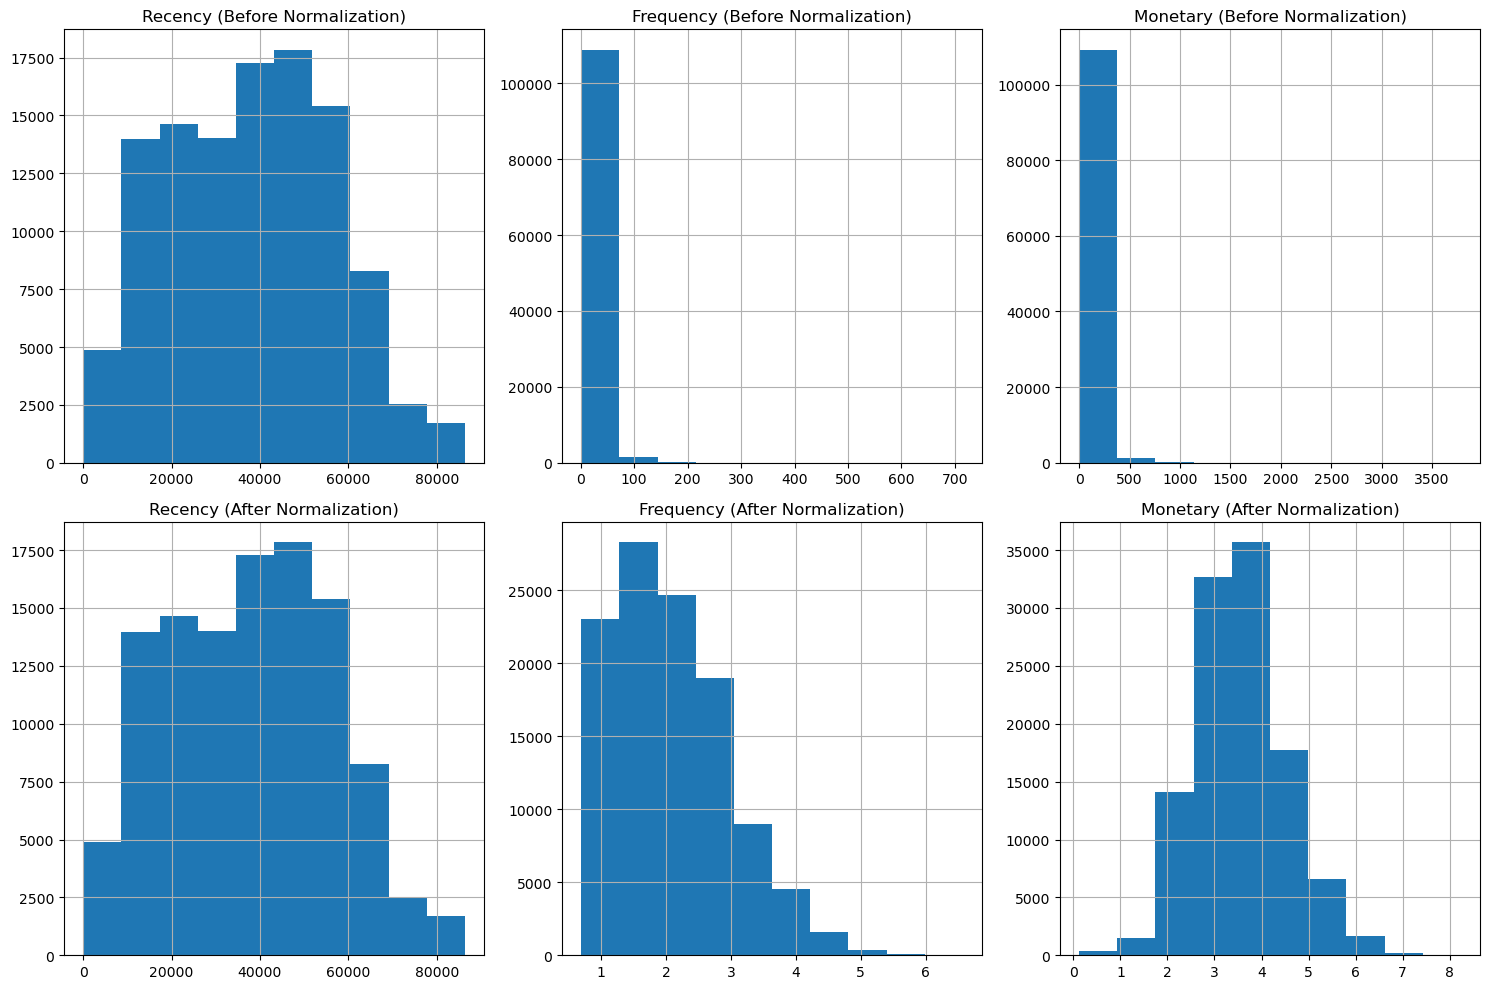

In [4]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

# Calculate Recency, Frequency, and Monetary metrics
latest_date = data['event_time'].max()
rfm_df = data[data['event_type'] == 'purchase'].groupby('user_id').agg({
    'event_time': lambda date: (latest_date - date.max()).seconds,
    'product_id': 'count',
    'price': 'sum'
}).reset_index()

# Before log normalization
plt.figure(figsize=(15, 10))
rfm_df.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']
# Plot histograms before normalization
plt.subplot(2, 3, 1)
rfm_df['Recency'].hist()
plt.title('Recency (Before Normalization)')

plt.subplot(2, 3, 2)
rfm_df['Frequency'].hist()
plt.title('Frequency (Before Normalization)')

plt.subplot(2, 3, 3)
rfm_df['Monetary'].hist()
plt.title('Monetary (Before Normalization)')

# After log normalization
# Perform log normalization
log_transform_columns = ['Frequency', 'Monetary']
rfm_df[log_transform_columns] = np.log1p(rfm_df[log_transform_columns])

# Plot histograms after normalization
plt.subplot(2, 3, 4)
rfm_df['Recency'].hist()
plt.title('Recency (After Normalization)')

plt.subplot(2, 3, 5)
rfm_df['Frequency'].hist()
plt.title('Frequency (After Normalization)')

plt.subplot(2, 3, 6)
rfm_df['Monetary'].hist()
plt.title('Monetary (After Normalization)')
plt.tight_layout()
plt.show()

# Standardize the RFM metrics using StandardScaler
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Convert the normalized array back to a DataFrame
rfm_normalized = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary'])

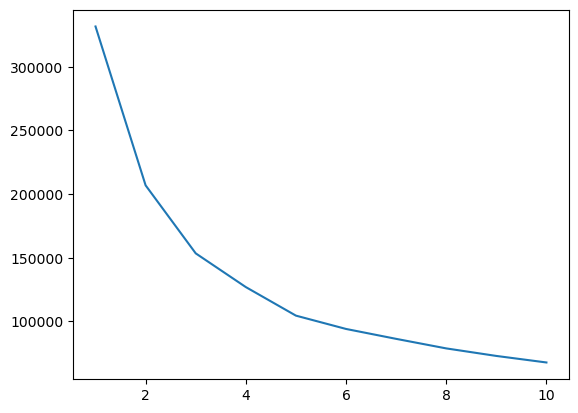

In [5]:

# Define a function to find the optimal number of clusters
def find_Optimal_n_clusters(k_means_data, n_clusters=10):
    DistanceList = []
    for i in range(1, n_clusters + 1):  # Test splitting the data into 1 to 10 clusters
        KM = KMeans(n_clusters=i, n_init='auto', random_state=1)
        KM.fit(k_means_data)
        DistanceList.append(KM.inertia_)  # Record the sum of squared distances of samples to their closest cluster center
    plt.plot(range(1, 11), DistanceList)
    plt.show()

find_Optimal_n_clusters(rfm_normalized, 10)

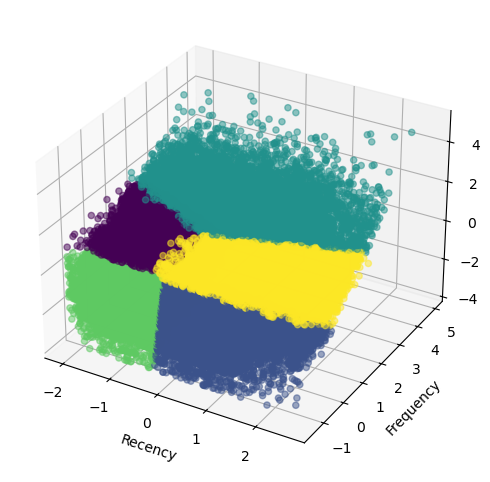

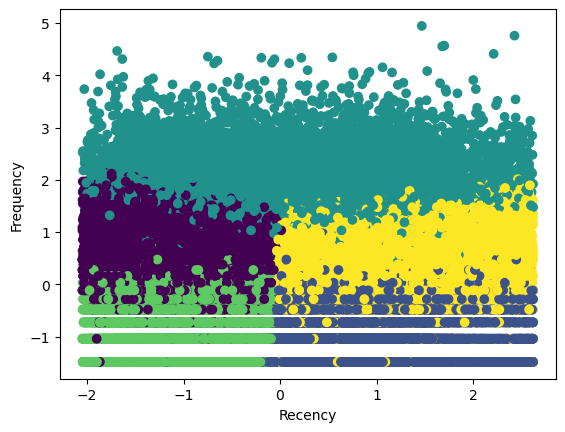

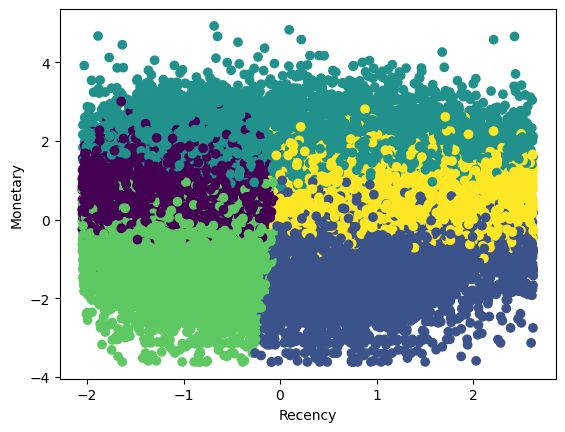

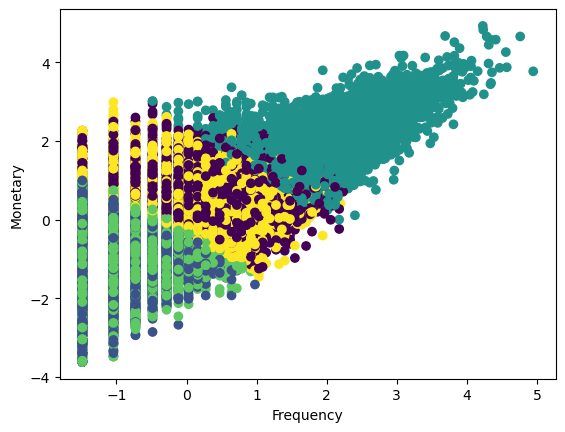

In [6]:
KM = KMeans(n_clusters=5, n_init='auto', random_state=1)
KM.fit(rfm_normalized)
def find_k_means_scatter_plot(df, model, feature_subset=None):
    if feature_subset is None:
        feature_subset = df.columns
    
    n_features = len(feature_subset)
    fig, axs = plt.subplots(n_features - 1, n_features - 1, figsize=(15, 15))
    labels = model.labels_
    
    for i in range(n_features - 1):
        for j in range(i + 1, n_features):
            ax = axs[i, j - 1]  # Adjusting subplot position
            ax.scatter(df[feature_subset[i]], df[feature_subset[j]], c=labels, cmap='viridis', alpha=0.5)
            ax.set_xlabel(feature_subset[i])
            ax.set_ylabel(feature_subset[j])

    plt.tight_layout()
    plt.show()

# # find_k_means_scatter_plot(k_means_data, KM, feature_subset=['avg_purchase_price', 'user_total_actions', 'user_total_session', 'user_avg_actions_per_session'])

def k_means_scatter_plot(x, y, df, model):
    plt.scatter(df[x], df[y], c=model.labels_, cmap='viridis')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

def k_means_scatter_plot_3d(x, y, z, df, model):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[x], df[y], df[z], c=model.labels_, cmap='viridis', alpha=0.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    plt.show()

k_means_scatter_plot_3d('Recency', 'Frequency', 'Monetary', rfm_normalized, KM)
k_means_scatter_plot('Recency', 'Frequency', rfm_normalized, KM)
k_means_scatter_plot('Recency', 'Monetary', rfm_normalized, KM)
k_means_scatter_plot('Frequency', 'Monetary', rfm_normalized, KM)

In [47]:
import os
from joblib import dump

# Ścieżka absolutna do katalogu i pliku
models_dir = r'C:\Users\nazwa\Documents\datascience\infoshare\big_data_project\jdszr16-datapaparapa\models'
model_path = os.path.join(models_dir, 'model_kmeans_cosmetic_05_org.joblib')

# Tworzenie katalogu 'models', jeśli nie istnieje
os.makedirs(models_dir, exist_ok=True)

# Zapis modelu do pliku w katalogu 'models'
dump(KM, model_path)

print(f"Model zapisany w: {model_path}")

Model zapisany w: C:\Users\nazwa\Documents\datascience\infoshare\big_data_project\jdszr16-datapaparapa\models\model_kmeans_cosmetic_05_org.joblib


* Analysis after labeling

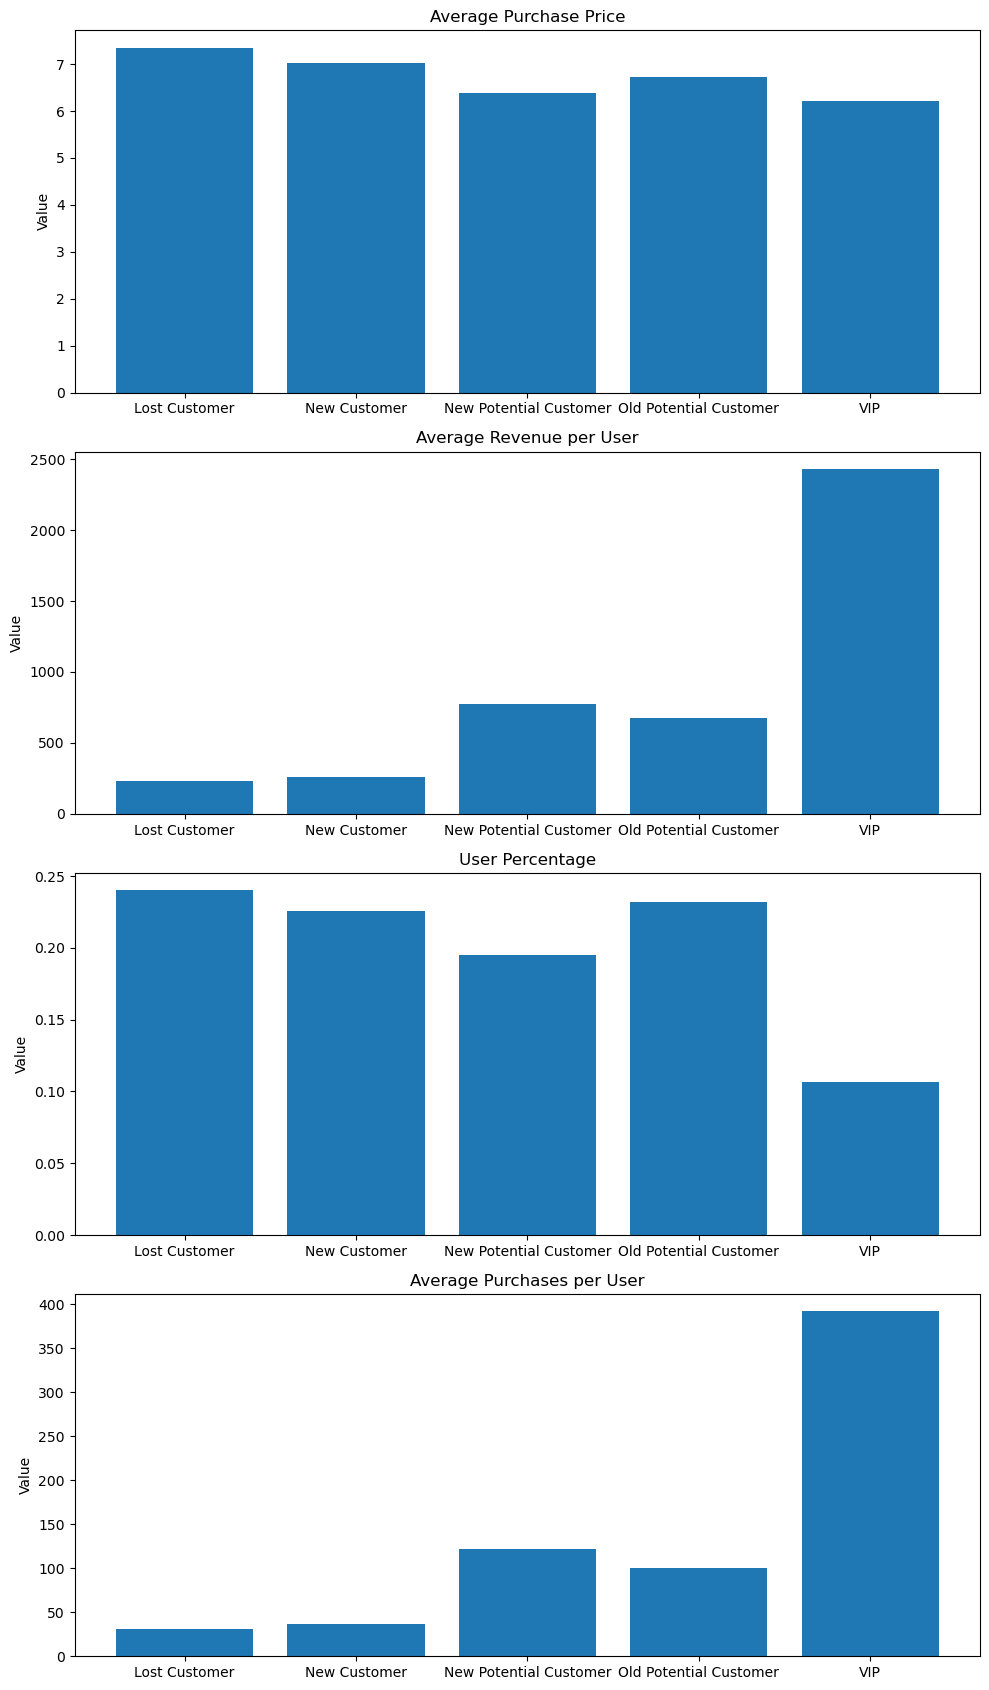

In [7]:
# Assign the RFM customer_type as the label for each data point
rfm_df['customer_type'] = KM.labels_
color_map = {0: 'New Potential Customer', 1: 'Lost Customer', 2: 'VIP', 3: 'New Customer', 4: 'Old Potential Customer'}
rfm_df['customer_type'] = rfm_df['customer_type'].map(color_map)

# Merge the data with the RFM customer_type label
merged_data = pd.merge(data, rfm_df[['user_id', 'customer_type']], on='user_id', how='left')

# Group the data by customer type
grouped_data = merged_data.groupby('customer_type')

# Perform analysis on each group
analysis_df = grouped_data.agg({'price': 'sum',
                                'product_id': 'count',
                                'user_id': 'nunique',})


def comparison_analysis(analysis_df):
    # Calculate the percentage of total revenue for each customer type
    analysis_df['revenue_per_user'] = (analysis_df['price'] / analysis_df['user_id'])

    # Calculate the percentage of users for each customer type
    analysis_df['user_percentage'] = (analysis_df['user_id'] / analysis_df['user_id'].sum())

    analysis_df['Average Purchases per User'] = analysis_df['product_id'] / analysis_df['user_id']

    analysis_df['Average Purchase Price'] = analysis_df['price'] / analysis_df['product_id']

    # Rename the columns for better readability
    analysis_df.columns = ['Total Revenue', 'Total Purchases', 'Total Users',
                        'Average Revenue per User', 'User Percentage', 'Average Purchases per User', 'Average Purchase Price']

    # Create four subplots
    fig, axes = plt.subplots(4, 1, figsize=(10, 17))

    # Plot Average Purchase Price
    axes[0].bar(analysis_df.index, analysis_df['Average Purchase Price'])
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Average Purchase Price')

    # Plot Average Revenue per User
    axes[1].bar(analysis_df.index, analysis_df['Average Revenue per User'])
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Value')
    axes[1].set_title('Average Revenue per User')

    # Plot User Percentage
    axes[2].bar(analysis_df.index, analysis_df['User Percentage'])
    axes[2].set_xlabel('')
    axes[2].set_ylabel('Value')
    axes[2].set_title('User Percentage')

    # Plot Average Purchases per User
    axes[3].bar(analysis_df.index, analysis_df['Average Purchases per User'])
    axes[3].set_xlabel('')
    axes[3].set_ylabel('Value')
    axes[3].set_title('Average Purchases per User')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

comparison_analysis(analysis_df)

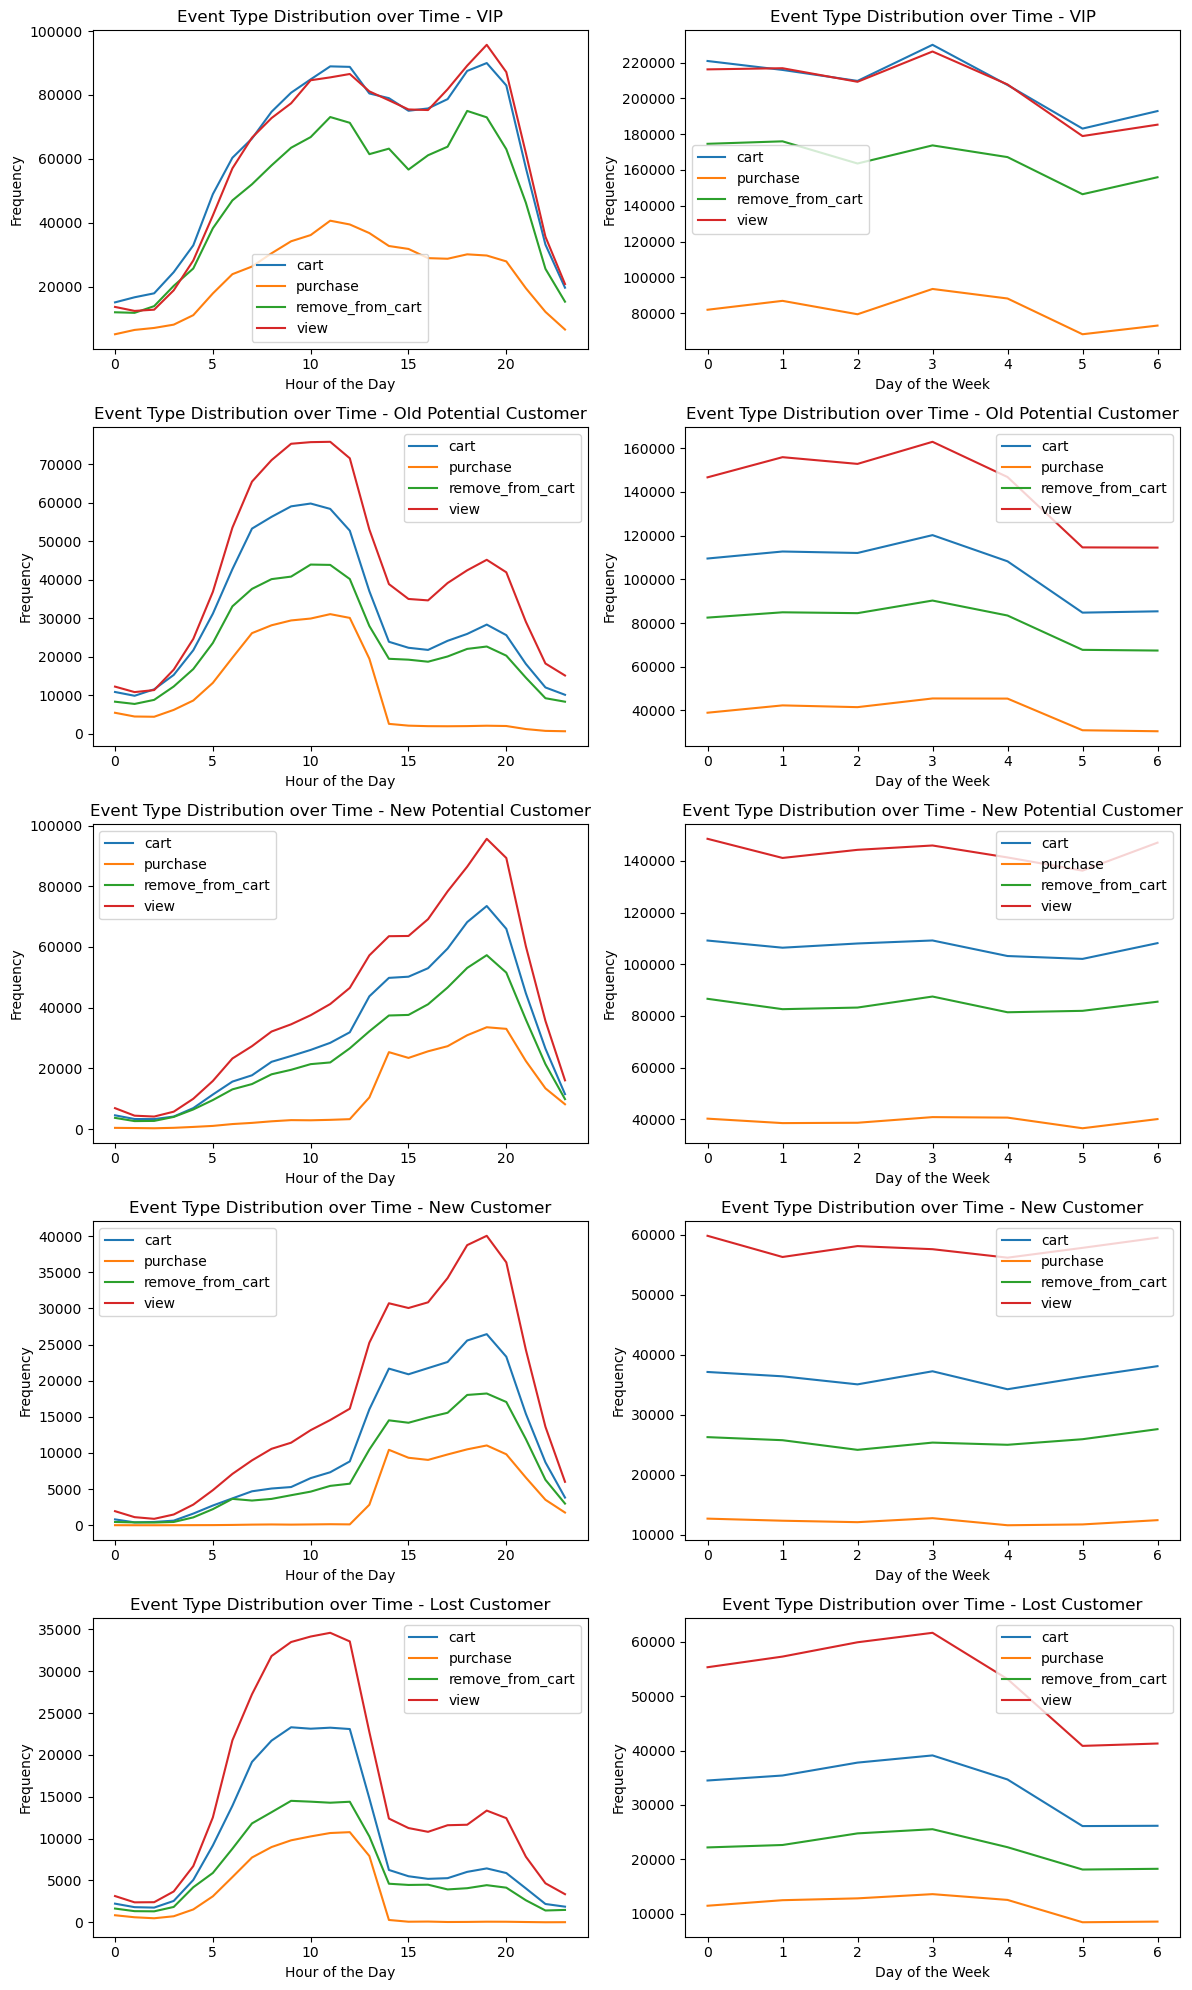

In [8]:
# Map customer_type to original data
customer_types = merged_data['customer_type'].dropna().unique()

# Create a figure and axes
fig, axs = plt.subplots(len(customer_types), 2, figsize=(12, 20))

# Iterate over each customer type
for i, customer_type in enumerate(customer_types):
    customer_data = merged_data[merged_data['customer_type'] == customer_type]
    # print(customer_data['event_time'].dt.hour)
    
    # Plot the event type distribution over time (hour of the day)
    ax = axs[i, 0]
    customer_data.groupby(customer_data['event_time'].dt.hour)['event_type'].value_counts().unstack().plot(kind='line', ax=ax)
    ax.set_title(f'Event Type Distribution over Time - {customer_type}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Plot the event type distribution over time (day of the week)
    ax = axs[i, 1]
    customer_data.groupby(customer_data['event_time'].dt.weekday)['event_type'].value_counts().unstack().plot(kind='line', ax=ax)
    ax.set_title(f'Event Type Distribution over Time - {customer_type}')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Delete variables to free up memory
#del customer_types, customer_data, fig, axs, i, customer_type, color_map, merged_data, grouped_data, analysis_df, rfm_df, rfm_normalized, KM

## K_means 用戶分群
* Find optimal n_clusters (elbow point)
  * In this case, 3 or 4 clusters is the most efficient choices

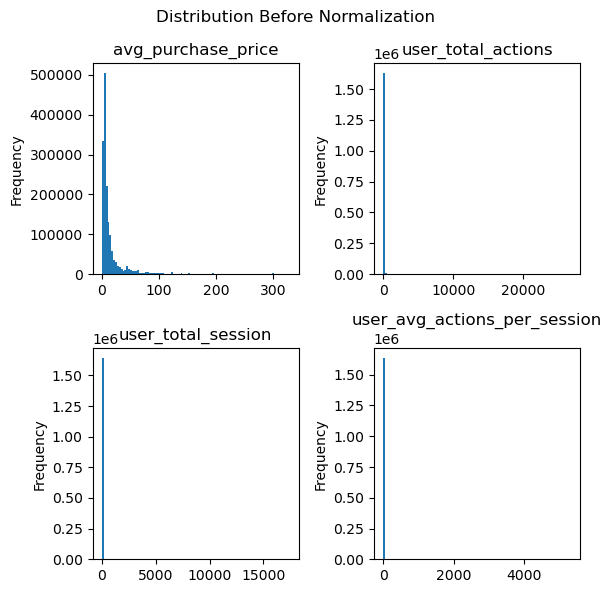

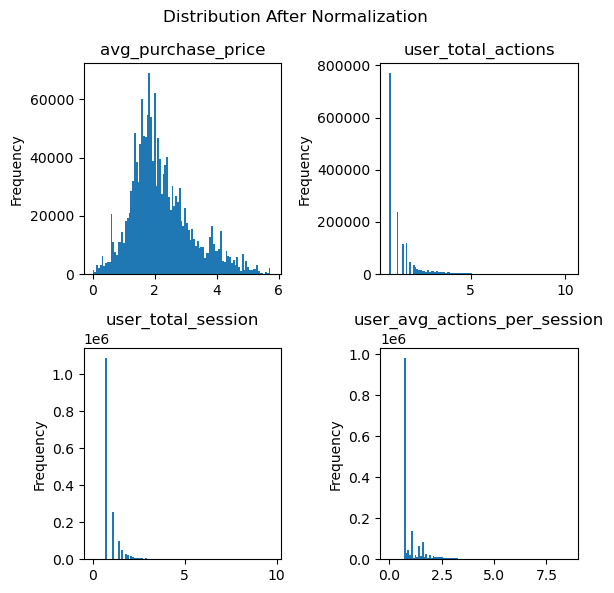

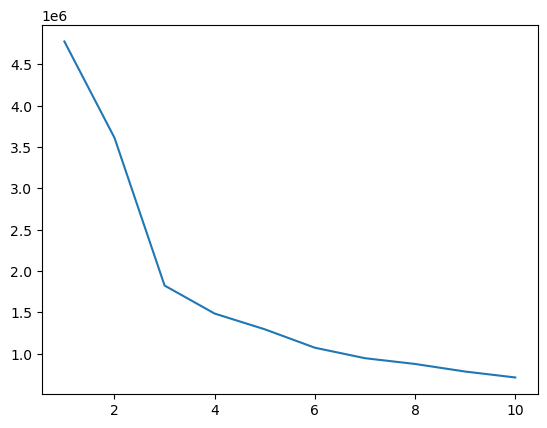

In [9]:
k_means_data = data.groupby('user_id').agg({'user_avg_actions_per_session': 'mean',
                                            'user_session': 'nunique',
                                            'price': 'mean', 
                                            'user_total_actions': 'mean'}).reset_index()
k_means_data = k_means_data[['price', 'user_total_actions', 'user_session', 'user_avg_actions_per_session']]

import math

def plot_histograms(data, title):
    # Get the number of columns in the DataFrame
    n_cols = data.shape[1]

    # Calculate the number of subplot rows and columns based on the number of columns
    n_subplot_rows = math.ceil(n_cols / 2)
    n_subplot_cols = min(n_cols, 2)

    # Create subplots dynamically
    fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(3 * n_subplot_cols, 3 * n_subplot_rows))

    # Flatten the axes if it's a single row or single column subplot
    if n_subplot_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_subplot_cols == 1:
        axes = axes.reshape(-1, 1)

    # Plot histograms for each column in the DataFrame
    for i, col in enumerate(data.columns):
        row_idx = i // n_subplot_cols
        col_idx = i % n_subplot_cols
        data[col].plot(kind='hist', bins=100, ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(col)

    # Adjust layout and display the plots
    fig.suptitle('{}'.format(title))
    plt.tight_layout()
    plt.show()

# Call the function with the k_means_data DataFrame
k_means_data = k_means_data.rename(columns={'price': 'avg_purchase_price', 'user_session': 'user_total_session'})
plot_histograms(k_means_data, 'Distribution Before Normalization')

# Normalization of data
log_transform_columns = ['avg_purchase_price', 'user_total_actions', 'user_total_session', 'user_avg_actions_per_session']
k_means_data[log_transform_columns] = np.log1p(k_means_data[log_transform_columns])

plot_histograms(k_means_data, 'Distribution After Normalization')

# Delete variables to free up memory
del log_transform_columns

# Normalize the data using StandardScaler
scaler = StandardScaler()
k_means_normalized = scaler.fit_transform(k_means_data)

# Find optimal number of clusters
find_Optimal_n_clusters(k_means_data, 10)

In [10]:
KM = KMeans(n_clusters=3, n_init='auto', random_state=1)
KM.fit(k_means_data)

KMeans(n_clusters=3, random_state=1)

* Find interpretable dimensions
  * average purchase price

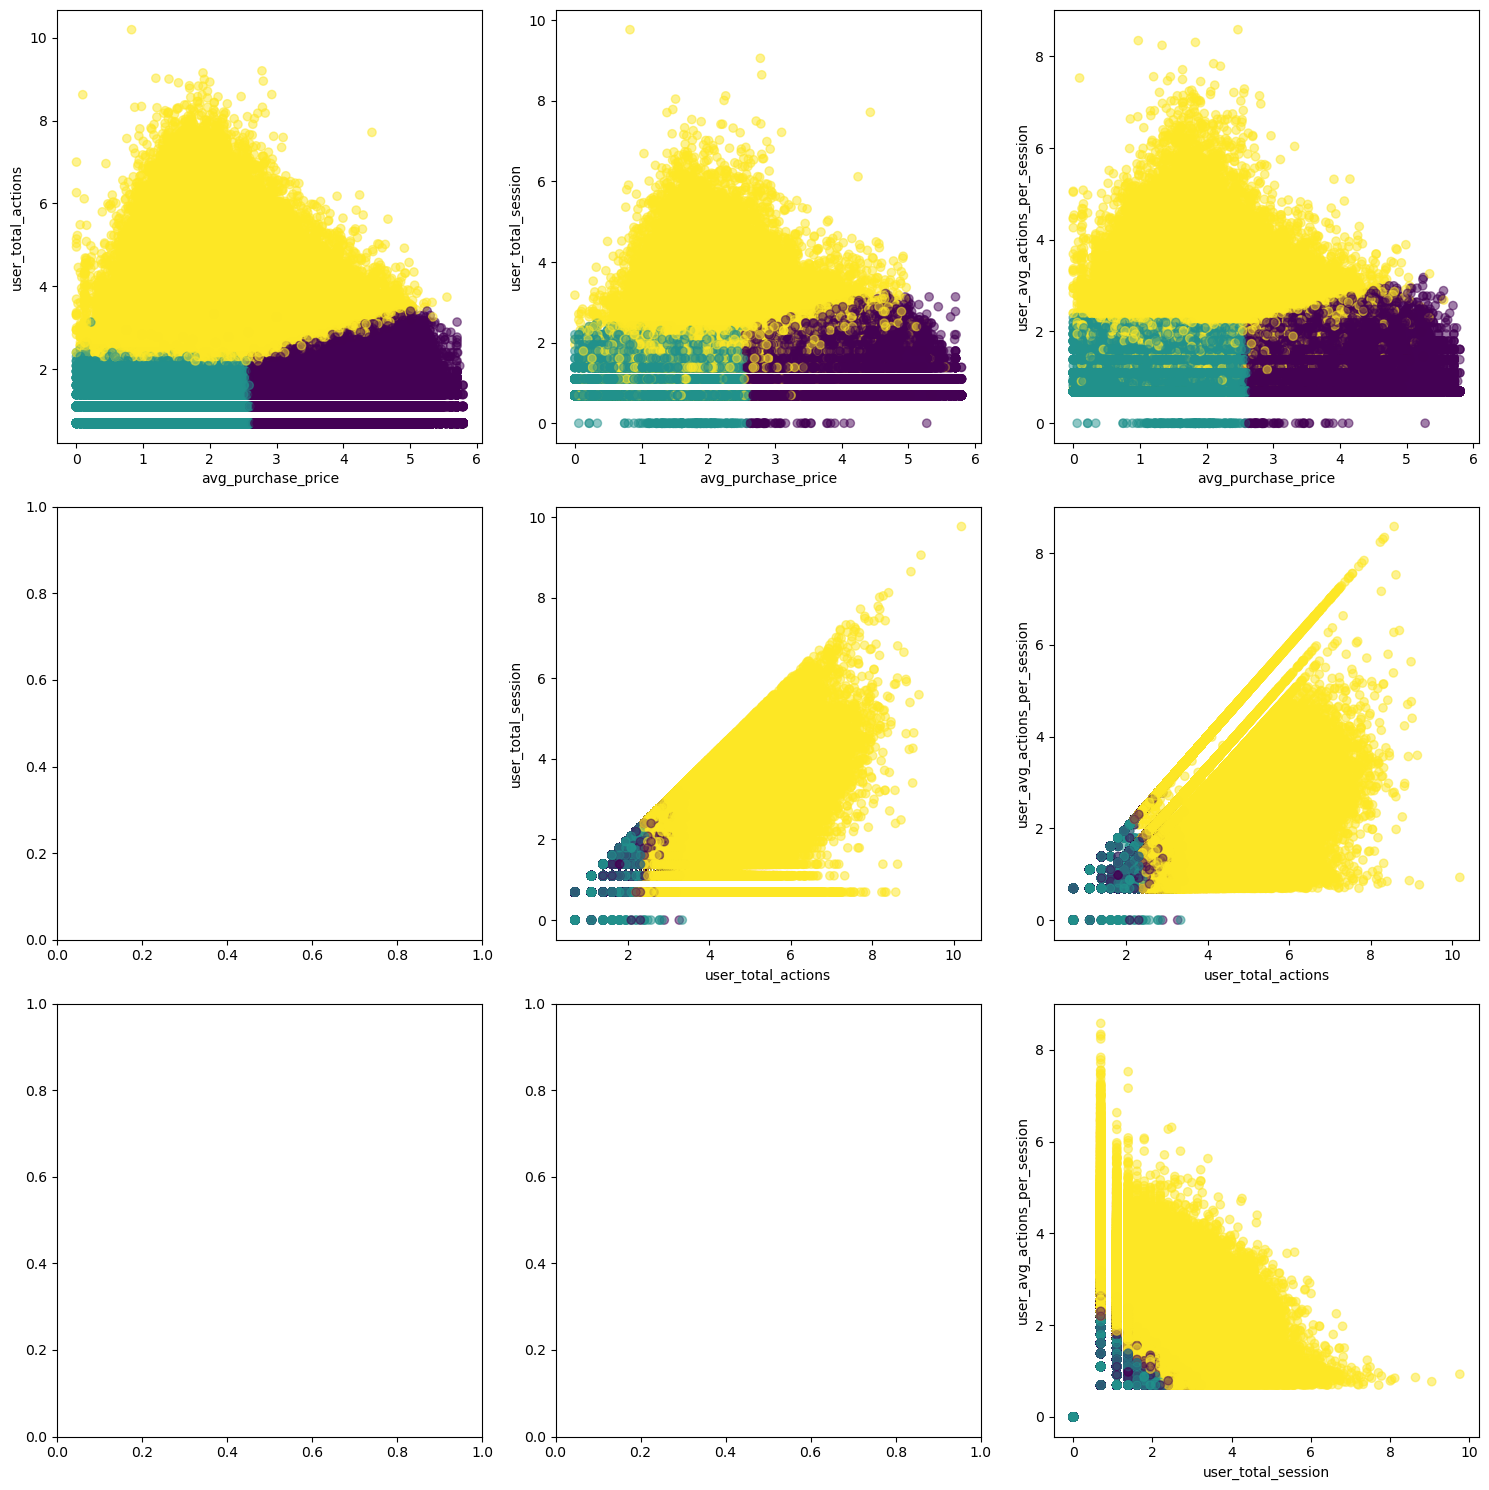

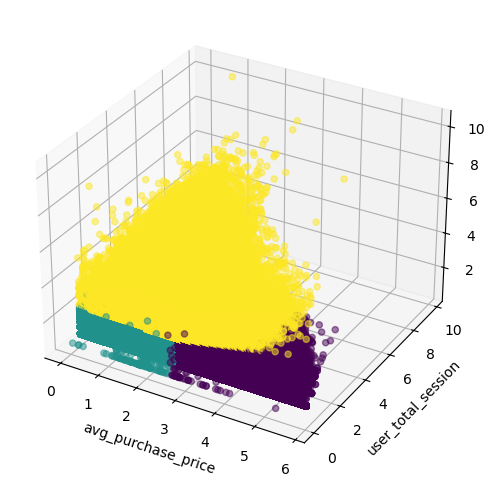

In [11]:
# ['avg_purchase_price', 'user_total_actions', 'user_total_session', 'user_avg_actions_per_session']
# k_means_scatter_plot('user_total_actions', 'avg_purchase_price', k_means_data, KM)
# k_means_scatter_plot('avg_purchase_price', 'user_total_actions', k_means_data, KM)
# k_means_scatter_plot('user_total_session', 'user_avg_actions_per_session', k_means_data, KM)
find_k_means_scatter_plot(k_means_data, KM)
k_means_scatter_plot_3d('avg_purchase_price', 'user_total_session', 'user_total_actions', k_means_data, KM)

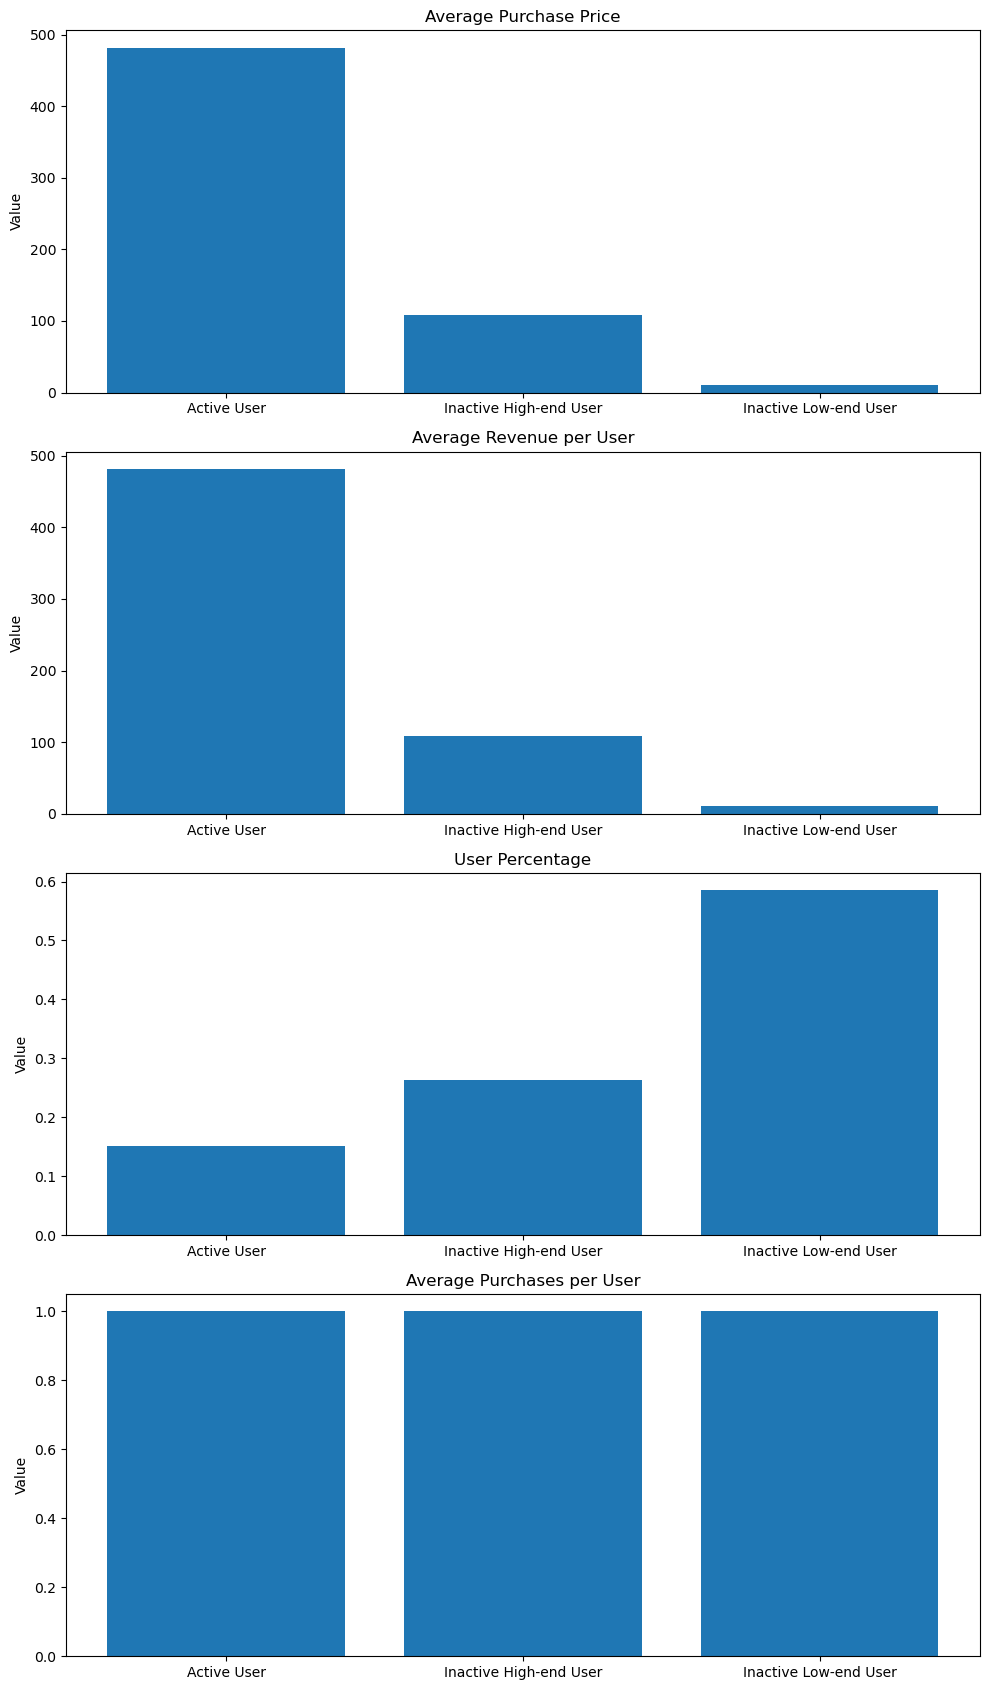

In [12]:
# Create a new DataFrame with the original data and the cluster labels
user_data = data[['price', 'product_id', 'user_id']].groupby('user_id').agg({'price': 'sum',
                                                                             'product_id': 'count'}).reset_index()

# print(user_data)
user_data['behavior_type'] = KM.labels_
color_map = {0: 'Inactive High-end User', 1: 'Inactive Low-end User', 2: 'Active User'}
user_data['behavior_type'] = user_data['behavior_type'].map(color_map)
user_data.columns = ['user_id', 'price', 'product_id', 'behavior_type']
grouped_data = user_data.groupby('behavior_type')

analysis_df = grouped_data.agg({'price': 'sum',
                                'product_id': 'count',
                                'user_id': 'nunique'})

comparison_analysis(analysis_df)

# Delete variables to free up memory
# del analysis_df, grouped_data, color_map, KM

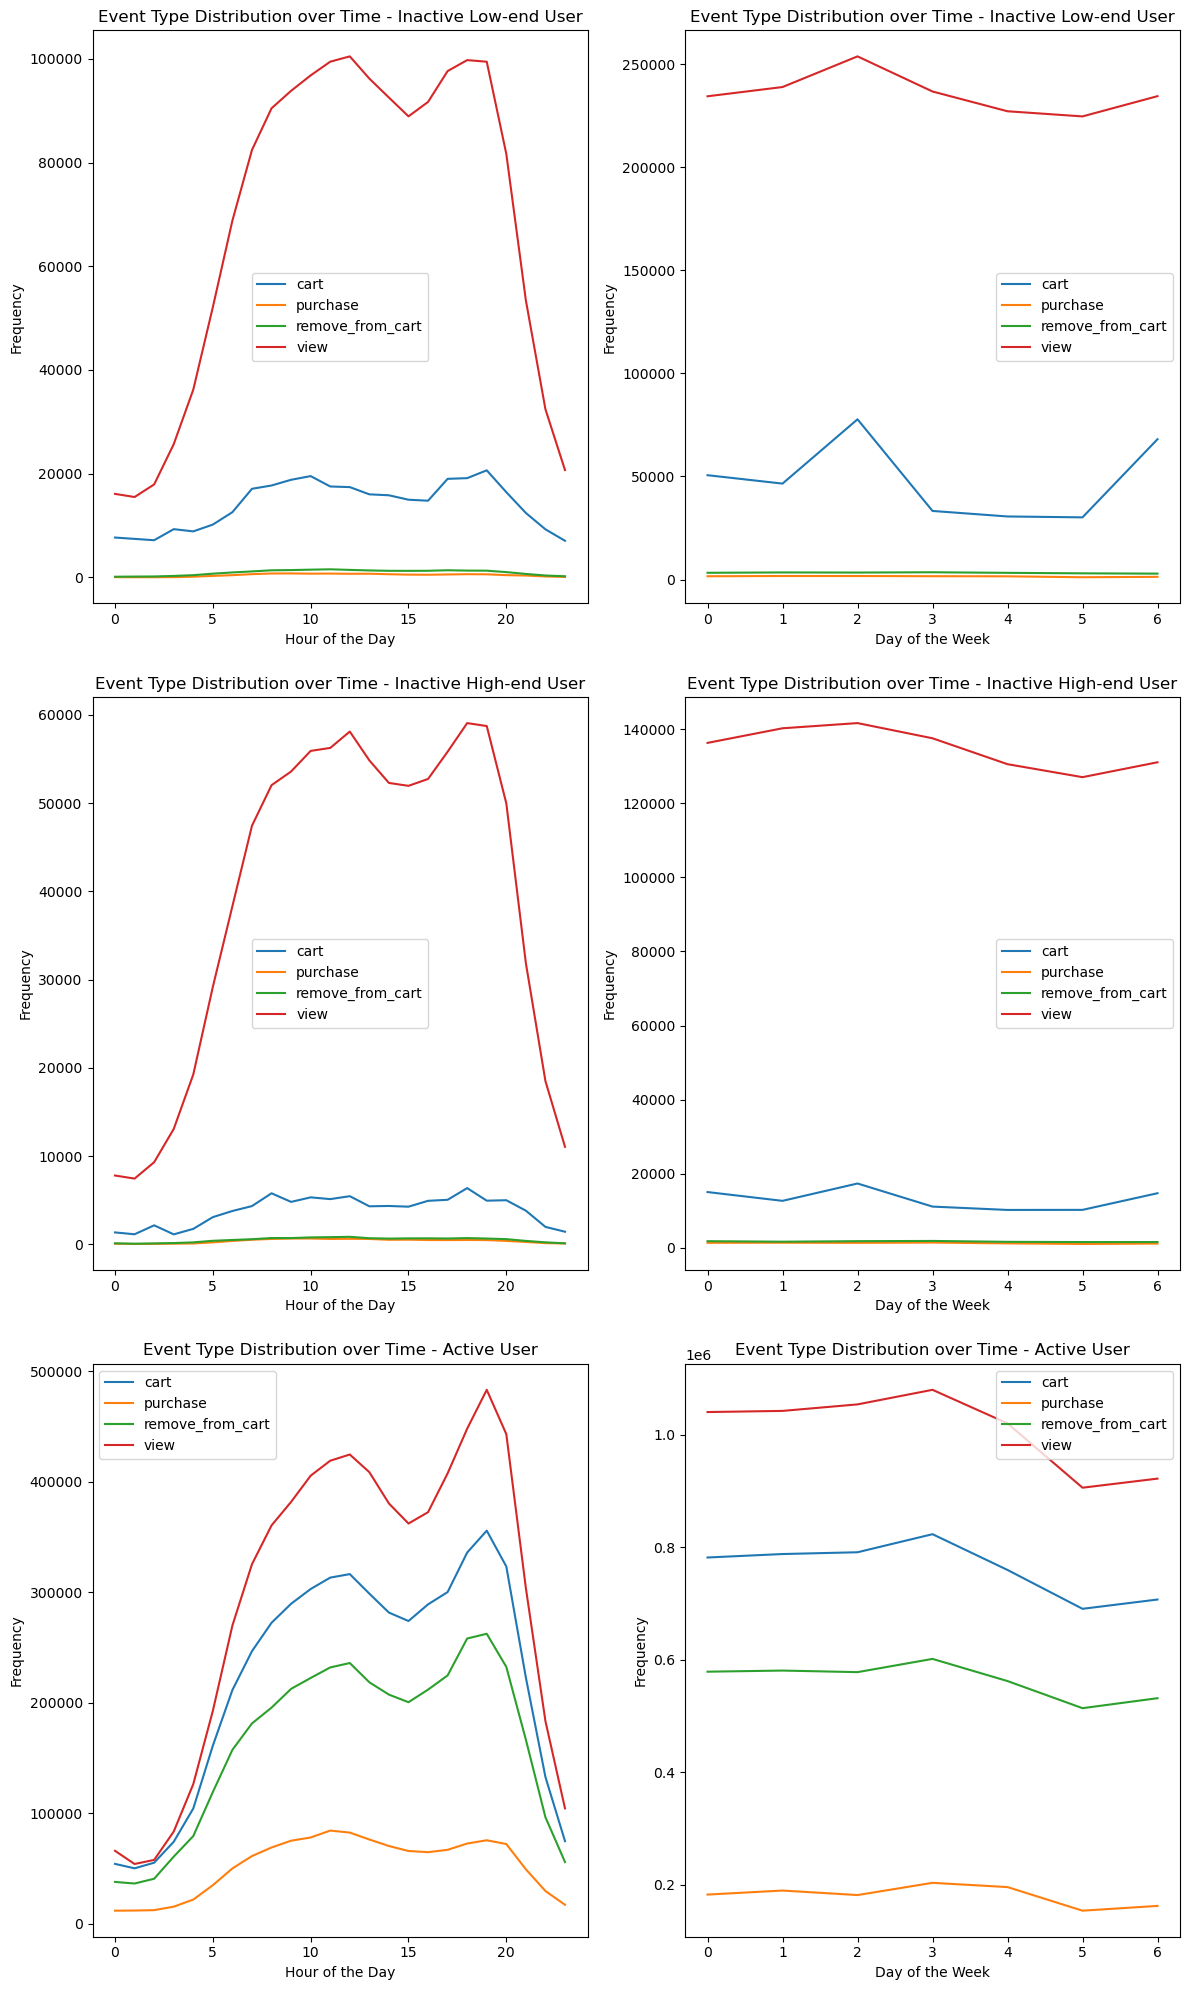

In [13]:
# map behavior_type to original data
data['behavior_type'] = data['user_id'].map(user_data.set_index('user_id')['behavior_type'])

behavior_types = user_data['behavior_type'].unique()

# Create a figure and axes
fig, axs = plt.subplots(len(behavior_types), 2, figsize=(12, 20))

# Iterate over each behavior type
for i, behavior_type in enumerate(behavior_types):
    behavior_data = data[data['behavior_type'] == behavior_type]

    # Plot the event type distribution over time (hour of the day)
    ax = axs[i, 0]
    behavior_data.groupby(behavior_data['event_time'].dt.hour)['event_type'].value_counts().unstack().plot(kind='line', ax=ax)
    ax.set_title(f'Event Type Distribution over Time - {behavior_type}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Plot the event type distribution over time (day of the week)
    ax = axs[i, 1]
    behavior_data.groupby(behavior_data['event_time'].dt.weekday)['event_type'].value_counts().unstack().plot(kind='line', ax=ax)
    ax.set_title(f'Event Type Distribution over Time - {behavior_type}')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Delete variables to free up memory
del behavior_types, behavior_data, fig, axs, i, behavior_type, user_data

## Market Basket Analysis
* Create Dataset for Basket Analysis, eliminate rows not purchasing
* Use 'brand' instead of 'product_id' simply because it's hard to find association rules

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def create_sparse_matrix(data, column):
    # Group by 'user_id' and concatenate values for each user
    grouped_data = data.groupby('user_id')[column].apply(lambda x: ' '.join(map(str, x)))
    
    # Use CountVectorizer
    vectorizer = CountVectorizer(binary=True, dtype=bool)
    sparse_matrix = vectorizer.fit_transform(grouped_data.astype(str))
    
    # Convert sparse matrix to DataFrame
    sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=vectorizer.get_feature_names_out())
    
    return sparse_df

# Filter and drop NaN values
brand_basket_data = data[data['event_type'] == 'purchase'][['user_id', 'brand']].dropna()
brand_basket_data['brand'] = brand_basket_data['brand'].apply(lambda x: x.replace('.', '_'))  # replace space with underscore
print(brand_basket_data['brand'].value_counts().sort_values(ascending=False).head(10))
category_basket_data = data[data['event_type'] == 'purchase'][['user_id', 'category_id']].dropna()

# Create sparse matrix for 'brand'
brand_sparse_df = create_sparse_matrix(brand_basket_data, 'brand')

# Create sparse matrix for 'category_id'
category_sparse_df = create_sparse_matrix(category_basket_data, 'category_id')

# Delete variables to free up memory
del brand_basket_data, category_basket_data

brand
runail       111408
irisk         73806
masura        49751
grattol       49542
bpw_style     37943
ingarden      27411
estel         19438
uno           17586
freedecor     17467
italwax       17105
Name: count, dtype: int64


C:\Users\nazwa\AppData\Local\Temp\ipykernel_14584\630070877.py:13: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=vectorizer.get_feature_names_out())
C:\Users\nazwa\AppData\Local\Temp\ipykernel_14584\630070877.py:13: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=vectorizer.get_feature_names_out())


* Get Association Rules

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np

def generate_association_rules(data_df, type, min_support=0.025, min_confidence=0.7):
    # Get frequent itemsets
    frequent_itemset = apriori(data_df, min_support=min_support, use_colnames=True)
    
    # Save frequent itemsets to CSV
    frequent_itemset.to_csv('./{}_apriori.csv'.format(type), index=False)
    
    # Generate association rules
    association_rules_df = association_rules(frequent_itemset, metric="confidence", min_threshold=min_confidence, num_itemsets=10)
     
    # Save association rules to CSV
    association_rules_df.to_csv('./{}_associationRules.csv'.format(type), index=False)
    
    # Drop duplicate rules
    df1 = pd.DataFrame(np.sort(association_rules_df[['antecedents','consequents']], axis=1), index=association_rules_df.index)
    association_rules_df = association_rules_df[~df1.duplicated()]
    
    return association_rules_df

# Call the function with the sparse matrix for product IDs
brand_association_rules = generate_association_rules(brand_sparse_df, 'brand', min_support=0.01, min_confidence=0.5)
category_association_rules = generate_association_rules(category_sparse_df, 'category_id', min_support=0.01, min_confidence=0.5)

# Delete variables to free up memory
del brand_sparse_df, category_sparse_df

* Visualizing Top 10 Rules

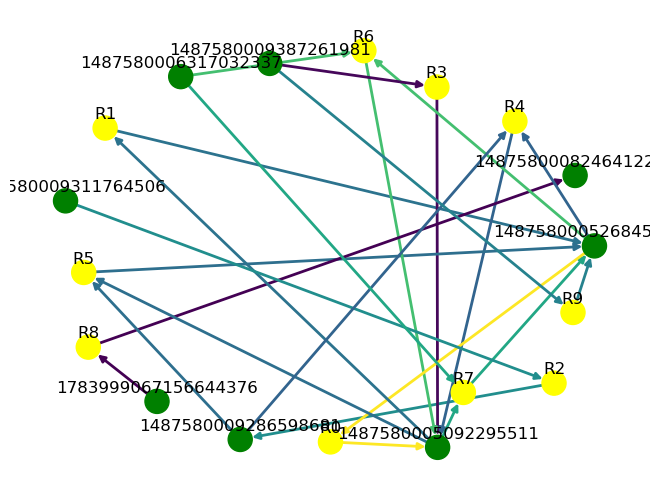

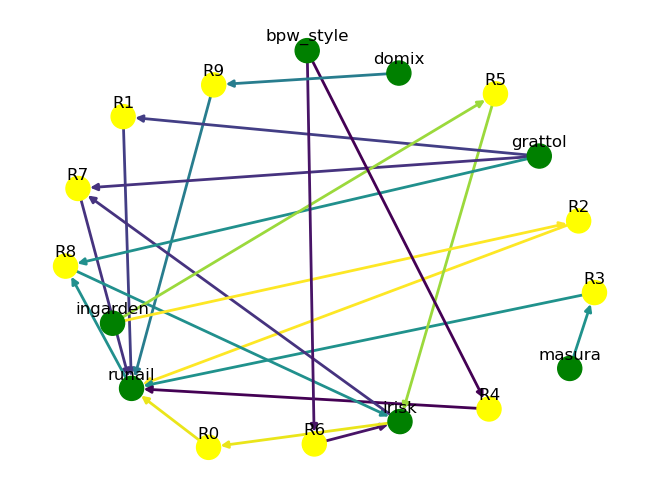

In [16]:
def draw_graph(rules, rules_to_show):
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt

    G1 = nx.DiGraph()

    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs = ['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

    for i in range(rules_to_show):
        G1.add_nodes_from(["R" + str(i)])

    for i in range(rules_to_show):
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R" + str(i), color=colors[i], weight=2)

        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R" + str(i), c, color=colors[i], weight=2)

    for node in G1:
        found_a_string = False
        for item in strs:
            if node == item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')

    edges = G1.edges()
    colors = [G1[u][v]['color'] for u, v in edges]
    weights = [G1[u][v]['weight'] for u, v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color=color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)

    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

draw_graph(category_association_rules.sort_values(['support', 'confidence', 'lift'], ascending=[False, False, False]), 10)
draw_graph(brand_association_rules.sort_values(['support', 'confidence', 'lift'], ascending=[False, False, False]), 10)

In [18]:
# Ile ma k_means_data?
k_means_data

,avg_purchase_price,user_total_actions,user_total_session,user_avg_actions_per_session
0,2.397895,1.386294,1.098612,0.916291
1,1.619388,0.693147,0.693147,0.693147
2,3.273364,0.693147,0.693147,0.693147
3,1.814930,3.465736,1.609438,2.169054
4,3.272606,0.693147,0.693147,0.693147
...,...,...,...,...
1639353,2.096790,1.098612,1.098612,0.693147
1639354,1.805005,1.386294,0.693147,1.386294
1639355,1.466722,1.098612,1.098612,0.693147
1639356,2.716680,0.693147,0.693147,0.693147


In [ ]:
KM.labels_.shape

In [20]:
# Ile ma KM.labels_?
KM.labels_.shape

(1639358,)

In [21]:
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Czas rozpoczęcia
start_time = time.time()

# 2. Klasteryzacja K-means
print("Rozpoczęcie klasteryzacji K-means...")
KM = KMeans(n_clusters=3, n_init='auto', random_state=1)
KM.fit(k_means_data)
num_clusters = len(set(KM.labels_))  # Upewnij się, że przypisujesz wartość num_clusters przed dalszymi obliczeniami
print(f"Czas klasteryzacji K-means: {time.time() - start_time} sekund")

# 3. Silhouette Score
print("Obliczanie Silhouette Score...")
silhouette = silhouette_score(k_means_data, KM.labels_)
print(f"Czas obliczenia Silhouette Score: {time.time() - start_time} sekund")

# 4. SSE (Sum of Squared Errors)
print("Obliczanie SSE...")
sse = KM.inertia_
print(f"Czas obliczenia SSE: {time.time() - start_time} sekund")

# 5. Liczba użytkowników w każdym klastrze
print("Obliczanie liczby użytkowników w każdym klastrze...")
unique, counts = np.unique(KM.labels_, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Czas obliczenia dystrybucji klastrów: {time.time() - start_time} sekund")

# 6. Profil klastrów (statystyki RFM)
print("Obliczanie profilu klastrów (RFM)...")
rfm_profile = k_means_data.groupby(KM.labels_).agg({
    'avg_purchase_price': ['mean', 'median', 'min', 'max'],
    'user_total_actions': ['mean', 'median', 'min', 'max'],
    'user_total_session': ['mean', 'median', 'min', 'max'],
    'user_avg_actions_per_session': ['mean', 'median', 'min', 'max']
})
print(f"Czas obliczenia profilu klastrów: {time.time() - start_time} sekund")

# 7. Najsilniejsza reguła
print("Obliczanie najlepszej reguły...")
best_rule = brand_association_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).iloc[0]
print(f"Czas obliczenia najlepszej reguły: {time.time() - start_time} sekund")

# 8. Liczba wygenerowanych reguł dla marek i kategorii
print("Obliczanie liczby reguł dla marek i kategorii...")
num_brand_rules = len(brand_association_rules)
num_category_rules = len(category_association_rules)
print(f"Czas obliczenia liczby reguł: {time.time() - start_time} sekund")

# 9. Support, Confidence, Lift dla marek
print("Obliczanie średnich wartości dla marek...")
avg_brand_support = brand_association_rules['support'].mean()
avg_brand_confidence = brand_association_rules['confidence'].mean()
avg_brand_lift = brand_association_rules['lift'].mean()
print(f"Czas obliczenia średnich dla marek: {time.time() - start_time} sekund")

# 10. Support, Confidence, Lift dla kategorii
print("Obliczanie średnich wartości dla kategorii...")
avg_category_support = category_association_rules['support'].mean()
avg_category_confidence = category_association_rules['confidence'].mean()
avg_category_lift = category_association_rules['lift'].mean()
print(f"Czas obliczenia średnich dla kategorii: {time.time() - start_time} sekund")

# 11. Liczba unikalnych antecedentów i consequentów
print("Obliczanie liczby unikalnych antecedentów i consequentów...")
unique_antecedents_brand = len(set([item for sublist in brand_association_rules['antecedents'] for item in sublist]))
unique_consequents_brand = len(set([item for sublist in brand_association_rules['consequents'] for item in sublist]))
unique_antecedents_category = len(set([item for sublist in category_association_rules['antecedents'] for item in sublist]))
unique_consequents_category = len(set([item for sublist in category_association_rules['consequents'] for item in sublist]))
print(f"Czas obliczenia unikalnych antecedentów i consequentów: {time.time() - start_time} sekund")

# 12. Średnia liczba produktów w regule (antecedent + consequent)
print("Obliczanie średniej liczby produktów w regule...")
avg_items_per_rule_brand = (brand_association_rules['antecedents'].apply(lambda x: len(x)) + brand_association_rules['consequents'].apply(lambda x: len(x))).mean()
avg_items_per_rule_category = (category_association_rules['antecedents'].apply(lambda x: len(x)) + category_association_rules['consequents'].apply(lambda x: len(x))).mean()
print(f"Czas obliczenia średniej liczby produktów w regule: {time.time() - start_time} sekund")

# 13. Liczba unikalnych produktów w antecedentach i consequentach
print("Obliczanie liczby unikalnych produktów...")
unique_products_brand = len(set([item for sublist in brand_association_rules['antecedents'] for item in sublist])) + \
                        len(set([item for sublist in brand_association_rules['consequents'] for item in sublist]))
unique_products_category = len(set([item for sublist in category_association_rules['antecedents'] for item in sublist])) + \
                           len(set([item for sublist in category_association_rules['consequents'] for item in sublist]))
print(f"Czas obliczenia liczby unikalnych produktów: {time.time() - start_time} sekund")

# 14. Podsumowanie metryk
print("Podsumowanie metryk...")
metrics = {
    'num_clusters': num_clusters,
    'silhouette_score': silhouette,
    'sse': sse,
    'cluster_distribution': cluster_distribution,
    'rfm_profile': rfm_profile,
    'best_rule': best_rule,
    'num_brand_rules': num_brand_rules,
    'num_category_rules': num_category_rules,
    'avg_brand_support': avg_brand_support,
    'avg_brand_confidence': avg_brand_confidence,
    'avg_brand_lift': avg_brand_lift,
    'avg_category_support': avg_category_support,
    'avg_category_confidence': avg_category_confidence,
    'avg_category_lift': avg_category_lift,
    'unique_antecedents_brand': unique_antecedents_brand,
    'unique_consequents_brand': unique_consequents_brand,
    'unique_antecedents_category': unique_antecedents_category,
    'unique_consequents_category': unique_consequents_category,
    'avg_items_per_rule_brand': avg_items_per_rule_brand,
    'avg_items_per_rule_category': avg_items_per_rule_category,
    'unique_products_brand': unique_products_brand,
    'unique_products_category': unique_products_category
}

# Wydrukowanie metryk
import pprint
pprint.pprint(metrics)

Rozpoczęcie klasteryzacji K-means...
Czas klasteryzacji K-means: 0.825946569442749 sekund
Obliczanie Silhouette Score...
Czas obliczenia Silhouette Score: 30622.50602221489 sekund
Obliczanie SSE...
Czas obliczenia SSE: 30622.509021520615 sekund
Obliczanie liczby użytkowników w każdym klastrze...
Czas obliczenia dystrybucji klastrów: 30622.5655708313 sekund
Obliczanie profilu klastrów (RFM)...
Czas obliczenia profilu klastrów: 30622.927119255066 sekund
Obliczanie najlepszej reguły...
Czas obliczenia najlepszej reguły: 30622.934134483337 sekund
Obliczanie liczby reguł dla marek i kategorii...
Czas obliczenia liczby reguł: 30622.935134649277 sekund
Obliczanie średnich wartości dla marek...
Czas obliczenia średnich dla marek: 30622.936150312424 sekund
Obliczanie średnich wartości dla kategorii...
Czas obliczenia średnich dla kategorii: 30622.937135457993 sekund
Obliczanie liczby unikalnych antecedentów i consequentów...
Czas obliczenia unikalnych antecedentów i consequentów: 30622.94213271